# Install Required Library

In [1]:
!pip install langdetect 
!pip install pyspark
!pip install tqdm

     |████████████████████████████████| 981 kB 889 kB/s            
  Preparing metadata (setup.py) ... - done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993242 sha256=12dab9addd0cf42bcdd04c40a20a318e6df9af53243253a918f221e7a32d7269
  Stored in directory: /root/.cache/pip/wheels/c5/96/8a/f90c59ed25d75e50a8c10a1b1c2d4c402e4dacfa87f3aff36a
Successfully built langdetect
     |████████████████████████████████| 281.3 MB 34 kB/s              
  Preparing metadata (setup.py) ... - done
     |████████████████████████████████| 198 kB 24.4 MB/s            
  Created wheel for pyspark: filename=pyspark-3.2.0-py2.py3-none-any.whl size=281805912 sha256=cef833fde2a96db65320d74b1398cc2da55687b1b4225f13143792d140e3660f
  Stored in directory: /root/.cache/pip/wheels/0b/de/d2/9be5d59d7331c6c2a7c1b6d1a4f463ce107332b1ecd4e80718
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.3
    Uninstalling py4j-0.10.9.3:
    

# Import Required Library

In [2]:
import numpy as np 
import pandas as pd 
from pandas import DataFrame
import os, json
import glob
import csv
from sklearn.feature_extraction import text
import string
from tqdm import tqdm
from langdetect import detect
from langdetect import DetectorFactory
import sys
import string
string.punctuation
from pprint import pprint

# Read Metadata File

In [3]:
metadataDF = pd.read_csv('../input/CORD-19-research-challenge/metadata.csv')

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


# Exploratory the Data 

In [4]:
metadataDF.head(2)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [5]:
metadataDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 866605 entries, 0 to 866604
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   cord_uid          866605 non-null  object 
 1   sha               293894 non-null  object 
 2   source_x          866605 non-null  object 
 3   title             866168 non-null  object 
 4   doi               489751 non-null  object 
 5   pmcid             305461 non-null  object 
 6   pubmed_id         390515 non-null  object 
 7   license           866605 non-null  object 
 8   abstract          653755 non-null  object 
 9   publish_time      866369 non-null  object 
 10  authors           846465 non-null  object 
 11  journal           809253 non-null  object 
 12  mag_id            0 non-null       float64
 13  who_covidence_id  400429 non-null  object 
 14  arxiv_id          11489 non-null   object 
 15  pdf_json_files    293894 non-null  object 
 16  pmc_json_files    24

In [6]:
metadataDF.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [7]:
len(metadataDF)

866605

#### Drop Null values of the Column pdf_json_files 
#### Take 3% as a sample of the Data to Proceed withit 

In [8]:
#drop rows that have empty pdf_json cels
metadataDF.dropna(subset=['pdf_json_files'], inplace=True)

#create a new df with first 1000 rows
covid_df = metadataDF.sample(int(len(metadataDF) *0.03))

print('Sample Data Rows:', len(covid_df))

Sample Data Rows: 8816


In [9]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8816 entries, 3492 to 767627
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          8816 non-null   object 
 1   sha               8816 non-null   object 
 2   source_x          8816 non-null   object 
 3   title             8816 non-null   object 
 4   doi               8476 non-null   object 
 5   pmcid             7885 non-null   object 
 6   pubmed_id         6974 non-null   object 
 7   license           8816 non-null   object 
 8   abstract          7561 non-null   object 
 9   publish_time      8816 non-null   object 
 10  authors           8745 non-null   object 
 11  journal           7997 non-null   object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  0 non-null      object 
 14  arxiv_id          353 non-null    object 
 15  pdf_json_files    8816 non-null   object 
 16  pmc_json_files    6891 non-null   obj

##### Clean Values of Column pdf_json_files to extract the path of the json file

In [10]:
#covid_df['pdf_json_files'] = covid_df['pdf_json_files'].str.rstrip('.json ')
covid_df["pdf_json_files"] = covid_df["pdf_json_files"].str.split(";").str[0]
covid_df.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
3492,y9la83zx,90b225bb89b9c6cd53621102fb383cf4fa090891,PMC,Gene Knockdowns in Adult Animals: PPMOs and Vi...,10.3390/molecules14031304,PMC6253989,19325525,cc-by,Antisense molecules do not readily cross cell ...,2009-03-25,"Moulton, Jon D.; Jiang, Shan",Molecules,NaN,NaN,NaN,document_parses/pdf_json/90b225bb89b9c6cd53621...,document_parses/pmc_json/PMC6253989.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN
865226,o6uak5b1,61c53a01cca751529f84193ba571fa471d1fc0ab,Medline; PMC,"Modeling the Binding Mechanism of Remdesivir, ...",10.1021/acscentsci.0c01242,PMC7805600,33527086.0,no-cc,[Image: see text] Recent efforts to repurpose ...,2021-01-06,"Byléhn, Fabian; Menéndez, Cintia A.; Perez-Lem...",ACS Cent Sci,NaN,NaN,NaN,document_parses/pdf_json/61c53a01cca751529f841...,document_parses/pmc_json/PMC7805600.xml.json,https://doi.org/10.1021/acscentsci.0c01242; ht...,231676250.0
50793,zpeupbef,018a5ebef45265eef3aa8e0125a5bdb62768f591,PMC,Pasture Monitoring Applying Normalized Differe...,10.1007/978-3-030-58817-5_41,PMC7975004,NaN,no-cc,The soils have had an increasing pressure due ...,2020-08-24,"Fernando, Garrido; Víctor, Caranqui",Computational Science and Its Applications - I...,NaN,NaN,NaN,document_parses/pdf_json/018a5ebef45265eef3aa8...,document_parses/pmc_json/PMC7975004.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN


##### Function to format body_text into block of text

In [11]:
def format_body(body_text):
    texts = [(di['section'], di['text']) for di in body_text]
    texts_di = {di['section']: "" for di in body_text}
    for section, text in texts:
        texts_di[section] += text
    body = ""
    for section, text in texts_di.items():
        body += section
        body += "\n\n"
        body += text
        body += "\n\n"
    body.encode('utf-8')
    return body

##### Load json files and extract the body then add it as a column in the dataset

In [12]:
path_to_json ='../input/CORD-19-research-challenge/'
body_text = []
for filename in covid_df['pdf_json_files']:
    filename = path_to_json + filename 
    my_json_file = json.load(open(filename, 'r'))
    body_text.append(format_body(my_json_file['body_text']))
covid_df['body_text'] = body_text
covid_df.head(3)

,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id,body_text
3492,y9la83zx,90b225bb89b9c6cd53621102fb383cf4fa090891,PMC,Gene Knockdowns in Adult Animals: PPMOs and Vi...,10.3390/molecules14031304,PMC6253989,19325525,cc-by,Antisense molecules do not readily cross cell ...,2009-03-25,"Moulton, Jon D.; Jiang, Shan",Molecules,NaN,NaN,NaN,document_parses/pdf_json/90b225bb89b9c6cd53621...,document_parses/pmc_json/PMC6253989.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,Introduction\n\nMorpholino oligos are steric-b...
865226,o6uak5b1,61c53a01cca751529f84193ba571fa471d1fc0ab,Medline; PMC,"Modeling the Binding Mechanism of Remdesivir, ...",10.1021/acscentsci.0c01242,PMC7805600,33527086.0,no-cc,[Image: see text] Recent efforts to repurpose ...,2021-01-06,"Byléhn, Fabian; Menéndez, Cintia A.; Perez-Lem...",ACS Cent Sci,NaN,NaN,NaN,document_parses/pdf_json/61c53a01cca751529f841...,document_parses/pmc_json/PMC7805600.xml.json,https://doi.org/10.1021/acscentsci.0c01242; ht...,231676250.0,■ INTRODUCTION\n\nA new coronavirus of zoonoti...
50793,zpeupbef,018a5ebef45265eef3aa8e0125a5bdb62768f591,PMC,Pasture Monitoring Applying Normalized Differe...,10.1007/978-3-030-58817-5_41,PMC7975004,NaN,no-cc,The soils have had an increasing pressure due ...,2020-08-24,"Fernando, Garrido; Víctor, Caranqui",Computational Science and Its Applications - I...,NaN,NaN,NaN,document_parses/pdf_json/018a5ebef45265eef3aa8...,document_parses/pmc_json/PMC7975004.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,Introduction\n\nLivestock in Ecuador depends o...


In [13]:
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8816 entries, 3492 to 767627
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   cord_uid          8816 non-null   object 
 1   sha               8816 non-null   object 
 2   source_x          8816 non-null   object 
 3   title             8816 non-null   object 
 4   doi               8476 non-null   object 
 5   pmcid             7885 non-null   object 
 6   pubmed_id         6974 non-null   object 
 7   license           8816 non-null   object 
 8   abstract          7561 non-null   object 
 9   publish_time      8816 non-null   object 
 10  authors           8745 non-null   object 
 11  journal           7997 non-null   object 
 12  mag_id            0 non-null      float64
 13  who_covidence_id  0 non-null      object 
 14  arxiv_id          353 non-null    object 
 15  pdf_json_files    8816 non-null   object 
 16  pmc_json_files    6891 non-null   obj

# Preparation and Cleaning the data

##### Select columns that will be used in the trasformation

In [14]:
SelectedFeature = covid_df[['cord_uid','title','abstract','body_text','doi', 'authors', 'journal', 'publish_time']]
SelectedFeature.info()
len(SelectedFeature) 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8816 entries, 3492 to 767627
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cord_uid      8816 non-null   object
 1   title         8816 non-null   object
 2   abstract      7561 non-null   object
 3   body_text     8816 non-null   object
 4   doi           8476 non-null   object
 5   authors       8745 non-null   object
 6   journal       7997 non-null   object
 7   publish_time  8816 non-null   object
dtypes: object(8)
memory usage: 619.9+ KB


8816

#### Drop Duplicated values

In [15]:
SelectedFeature=SelectedFeature.drop_duplicates(['abstract','body_text'])
len(SelectedFeature)

8816

#### Drop Null values

In [16]:
SelectedFeature.dropna(inplace = True)
len(SelectedFeature)

6735

#### Determine the Languge of each article

In [17]:
# set seed
DetectorFactory.seed = 0
# hold label - language
languages = []
# go through each text
for ii in tqdm(range(0,len(SelectedFeature))):
    # split by space into list, take the first x intex, join with space
    text = SelectedFeature.iloc[ii]['body_text'].split(" ")
    lang = "en"
    try:
        if len(text) > 50:
            lang = detect(" ".join(text[:50]))
        elif len(text) > 0:
            lang = detect(" ".join(text[:len(text)]))
    # ught... beginning of the document was not in a good format
    except Exception as e:
        all_words = set(text)
        try:
            lang = detect(" ".join(all_words))
        # what!! :( let's see if we can find any text in abstract...
        except Exception as e: 
            try:
                # let's try to label it through the abstract then
                lang = detect(df.iloc[ii]['abstract_summary'])
            except Exception as e:
                lang = "unknown"
                pass
    
    # get the language    
    languages.append(lang)

100%|██████████| 6735/6735 [00:56<00:00, 119.71it/s]


##### Showing the count of each languge article exist in dataset

In [18]:
languages_dict = {}
for lang in set(languages):
    languages_dict[lang]= languages.count(lang)
    
print("Total: {}\n".format(len(languages)))
pprint(languages_dict)

Total: 6735

{'de': 62,
 'en': 6616,
 'es': 23,
 'et': 1,
 'fr': 17,
 'nl': 6,
 'pt': 6,
 'so': 1,
 'sv': 1,
 'tl': 2}


#### Add Column Languge to the Dataframe 

In [19]:
SelectedFeature['language'] = languages

In [20]:
SelectedFeature.head(3)

,cord_uid,title,abstract,body_text,doi,authors,journal,publish_time,language
3492,y9la83zx,Gene Knockdowns in Adult Animals: PPMOs and Vi...,Antisense molecules do not readily cross cell ...,Introduction\n\nMorpholino oligos are steric-b...,10.3390/molecules14031304,"Moulton, Jon D.; Jiang, Shan",Molecules,2009-03-25,en
865226,o6uak5b1,"Modeling the Binding Mechanism of Remdesivir, ...",[Image: see text] Recent efforts to repurpose ...,■ INTRODUCTION\n\nA new coronavirus of zoonoti...,10.1021/acscentsci.0c01242,"Byléhn, Fabian; Menéndez, Cintia A.; Perez-Lem...",ACS Cent Sci,2021-01-06,en
50793,zpeupbef,Pasture Monitoring Applying Normalized Differe...,The soils have had an increasing pressure due ...,Introduction\n\nLivestock in Ecuador depends o...,10.1007/978-3-030-58817-5_41,"Fernando, Garrido; Víctor, Caranqui",Computational Science and Its Applications - I...,2020-08-24,en


#### Filter the Article in English Languge

In [21]:
SelectedFeatureEN = SelectedFeature[SelectedFeature['language'] == 'en']
SelectedFeatureEN = SelectedFeatureEN[['cord_uid','title','abstract','body_text', 'doi', 'authors', 'journal', 'publish_time']]
SelectedFeatureEN.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6616 entries, 3492 to 724672
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   cord_uid      6616 non-null   object
 1   title         6616 non-null   object
 2   abstract      6616 non-null   object
 3   body_text     6616 non-null   object
 4   doi           6616 non-null   object
 5   authors       6616 non-null   object
 6   journal       6616 non-null   object
 7   publish_time  6616 non-null   object
dtypes: object(8)
memory usage: 465.2+ KB


#### Define the function to remove the punctuation

In [22]:
def remove_punctuations(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text
# Apply to the DF series
SelectedFeatureEN['title'] = SelectedFeatureEN['title'].apply(remove_punctuations)
SelectedFeatureEN['abstract'] = SelectedFeatureEN['abstract'].apply(remove_punctuations)
SelectedFeatureEN['body_text'] = SelectedFeatureEN['body_text'].apply(remove_punctuations)
SelectedFeatureEN.head(3) 

,cord_uid,title,abstract,body_text,doi,authors,journal,publish_time
3492,y9la83zx,Gene Knockdowns in Adult Animals PPMOs and Viv...,Antisense molecules do not readily cross cell ...,Introduction\n\nMorpholino oligos are stericbl...,10.3390/molecules14031304,"Moulton, Jon D.; Jiang, Shan",Molecules,2009-03-25
865226,o6uak5b1,Modeling the Binding Mechanism of Remdesivir F...,Image see text Recent efforts to repurpose dru...,■ INTRODUCTION\n\nA new coronavirus of zoonoti...,10.1021/acscentsci.0c01242,"Byléhn, Fabian; Menéndez, Cintia A.; Perez-Lem...",ACS Cent Sci,2021-01-06
50793,zpeupbef,Pasture Monitoring Applying Normalized Differe...,The soils have had an increasing pressure due ...,Introduction\n\nLivestock in Ecuador depends o...,10.1007/978-3-030-58817-5_41,"Fernando, Garrido; Víctor, Caranqui",Computational Science and Its Applications - I...,2020-08-24


#### Set all words in lower case

In [23]:
SelectedFeatureEN['title']=SelectedFeatureEN['title'].str.lower()
SelectedFeatureEN['abstract']=SelectedFeatureEN['abstract'].str.lower()
SelectedFeatureEN['body_text']=SelectedFeatureEN['body_text'].str.lower()
SelectedFeatureEN.head(3) 

,cord_uid,title,abstract,body_text,doi,authors,journal,publish_time
3492,y9la83zx,gene knockdowns in adult animals ppmos and viv...,antisense molecules do not readily cross cell ...,introduction\n\nmorpholino oligos are stericbl...,10.3390/molecules14031304,"Moulton, Jon D.; Jiang, Shan",Molecules,2009-03-25
865226,o6uak5b1,modeling the binding mechanism of remdesivir f...,image see text recent efforts to repurpose dru...,■ introduction\n\na new coronavirus of zoonoti...,10.1021/acscentsci.0c01242,"Byléhn, Fabian; Menéndez, Cintia A.; Perez-Lem...",ACS Cent Sci,2021-01-06
50793,zpeupbef,pasture monitoring applying normalized differe...,the soils have had an increasing pressure due ...,introduction\n\nlivestock in ecuador depends o...,10.1007/978-3-030-58817-5_41,"Fernando, Garrido; Víctor, Caranqui",Computational Science and Its Applications - I...,2020-08-24


#### Remove Comman/Custom Stop Words

In [24]:
from sklearn.feature_extraction import text
import string
STOP_WORDS = text.ENGLISH_STOP_WORDS
punctuations = string.punctuation
StopWords = list(STOP_WORDS)

CustomStopWords = [
    'doi', 'preprint', 'copyright', 'peer', 'reviewed', 'org', 'https', 'et', 'al', 'author', 'figure', 
    'rights', 'reserved', 'permission', 'used', 'using', 'biorxiv', 'medrxiv', 'license', 'fig', 'fig.', 
    'al.', 'Elsevier', 'PMC', 'CZI', 'www'
]

for word in CustomStopWords:
    if word not in StopWords:
        StopWords.append(word)
        
SelectedFeatureEN['title'] = SelectedFeatureEN['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (StopWords)]))
SelectedFeatureEN['abstract'] = SelectedFeatureEN['abstract'].apply(lambda x: ' '.join([word for word in x.split() if word not in (StopWords)]))
SelectedFeatureEN['body_text'] = SelectedFeatureEN['body_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (StopWords)]))


SelectedFeatureEN.head(3)

,cord_uid,title,abstract,body_text,doi,authors,journal,publish_time
3492,y9la83zx,gene knockdowns adult animals ppmos vivomorpho...,antisense molecules readily cross cell membran...,introduction morpholino oligos stericblocking ...,10.3390/molecules14031304,"Moulton, Jon D.; Jiang, Shan",Molecules,2009-03-25
865226,o6uak5b1,modeling binding mechanism remdesivir favilavi...,image text recent efforts repurpose drugs comb...,■ introduction new coronavirus zoonotic origin...,10.1021/acscentsci.0c01242,"Byléhn, Fabian; Menéndez, Cintia A.; Perez-Lem...",ACS Cent Sci,2021-01-06
50793,zpeupbef,pasture monitoring applying normalized differe...,soils increasing pressure intensification use ...,introduction livestock ecuador depends grazing...,10.1007/978-3-030-58817-5_41,"Fernando, Garrido; Víctor, Caranqui",Computational Science and Its Applications - I...,2020-08-24


#### Saving Trasformed Data as Parquet

In [25]:
SelectedFeatureEN.to_parquet("./Newdf.parquet")

#### Load trasformed Data in spark Data frame in 4 Partitions

In [26]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import * 
from pyspark.ml.feature import StringIndexer ,OneHotEncoder,VectorAssembler
from pyspark.ml import Pipeline


spark = SparkSession \
    .builder \
    .appName('Covid') \
    .getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/01/05 20:53:34 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [27]:
spark.conf.set("spark.sql.shuffle.partitions", "4")
print("spark.sql.shuffle.partitions",spark.conf.get('spark.sql.shuffle.partitions'))
print("spark.sparkContext.defaultParallelism",spark.sparkContext.defaultParallelism)
print("spark.sql.files.maxPartitionBytes" , spark.conf.get('spark.sql.files.maxPartitionBytes'))
print("spark.sql.files.maxRecordsPerFile",spark.conf.get('spark.sql.files.maxRecordsPerFile'))

spark.sql.shuffle.partitions 4
spark.sparkContext.defaultParallelism 4
spark.sql.files.maxPartitionBytes 134217728b
spark.sql.files.maxRecordsPerFile 0


In [28]:
#DataSet =spark.read.parquet("../input/dataoutput/Newdf.parquet").repartition(4)
DataSet =spark.read.parquet("./Newdf.parquet").repartition(4)
DataSet.printSchema()

root
 |-- cord_uid: string (nullable = true)
 |-- title: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- body_text: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- authors: string (nullable = true)
 |-- journal: string (nullable = true)
 |-- publish_time: string (nullable = true)
 |-- __index_level_0__: long (nullable = true)



In [29]:
print("Number of Partitions",DataSet.rdd.getNumPartitions())
DataSet.select(spark_partition_id().alias("partitionId")).groupBy("partitionId").count().show()

Number of Partitions 4
+-----------+-----+
|partitionId|count|
+-----------+-----+
|          0| 1654|
|          1| 1654|
|          2| 1654|
|          3| 1654|
+-----------+-----+



#### Rename the Dataframe Columns

In [30]:
DataSet = DataSet.select('cord_uid','title','abstract','body_text', 'doi', 'authors', 'journal', 'publish_time')\
                .toDF("Id","Title","Abstract","Body",'Doi', 'Authors', 'Journal', 'PublishTime')

#'doi', 'authors', 'journal', 'publish_time'
DataSet.limit(3).toPandas()

,Id,Title,Abstract,Body,Doi,Authors,Journal,PublishTime
0,n6wrmlux,privacyprotecting reliable response data disco...,objective utilize individual institutional pri...,introduction covid19 pandemic represents water...,10.1093/jamia/ocab054,"Kim, Jihoon; Neumann, Larissa; Paul, Paulina; ...",J Am Med Inform Assoc,2021-05-29
1,w5pt48zc,covid19 prevention control measures community,january 30 2020 declared covid19 outbreak publ...,introduction late 2019 novel coronavirus desig...,10.3906/sag-2004-146,"GÜNER, Rahmet; HASANOĞLU, İmran; AKTAŞ, Firdevs",Turk J Med Sci,2020-04-21
2,okzn8ked,broadening impact plant science innovative int...,population growth climate change impact food s...,3 28 friesner broad impact current relevant fu...,10.1002/pld3.316,"Friesner, Joanna; Colón‐Carmona, Adán; Schnoes...",Plant Direct,2021-04-14


#### Check the Null values

In [31]:
for thisCol in DataSet.columns :
    print('The Count of Null in Column %s ' %thisCol , DataSet.where(col(thisCol).isNull()).count() )

The Count of Null in Column Id  0
The Count of Null in Column Title  0
The Count of Null in Column Abstract  0
The Count of Null in Column Body  0
The Count of Null in Column Doi  0
The Count of Null in Column Authors  0
The Count of Null in Column Journal  0
The Count of Null in Column PublishTime  0


# Vectorization

#### Transform texts to Vector

In [32]:
'''

TF: HashingTF is a Transformer which takes sets of terms and converts those sets into fixed-length feature vectors. 
In text processing, a “set of terms” might be a bag of words. The algorithm combines Term Frequency (TF) counts with the hashing 
trick for dimensionality reduction.

IDF: IDF is an Estimator which fits on a dataset and produces an IDFModel. The IDFModel takes feature vectors (generally 
created from HashingTF) and scales each column. Intuitively, it down-weights columns which appear frequently in a corpus.

Please refer to the MLlib user guide on TF-IDF for more details on Term Frequency and Inverse Document Frequency. For API 
details, refer to the HashingTF API docs and the IDF API docs.

In the following code segment, we start with a set of sentences. We split each sentence into words using Tokenizer. For each 
sentence (bag of words), we use HashingTF to hash the sentence into a feature vector. We use IDF to rescale the feature vectors; 
this generally improves performance when using text as features. Our feature vectors could then be passed to a learning algorithm.
'''


from pyspark.ml.feature import HashingTF, IDF, Tokenizer
rescaledData=DataSet
for thisCol in rescaledData.select('Title','Abstract','Body').columns :
    OutCol =thisCol+'Vector'
    tokenizer = Tokenizer(inputCol=thisCol , outputCol="words")
    wordsData = tokenizer.transform(rescaledData)

    hashingTF = HashingTF(inputCol="words", outputCol="rawFeatures", numFeatures=20)
    featurizedData = hashingTF.transform(wordsData)

    idf = IDF(inputCol="rawFeatures", outputCol=OutCol)
    idfModel = idf.fit(featurizedData)
    rescaledData = idfModel.transform(featurizedData)

    rescaledData=rescaledData.drop('words','rawFeatures')  
    

#### Divide Date column into three column Day ,Month , Year

In [33]:
rescaledData=rescaledData.withColumn('Day_PublishTime' ,  substring('PublishTime', 9,2).cast(IntegerType()))\
                        .withColumn('Month_PublishTime' ,  substring('PublishTime', 6,2).cast(IntegerType()))\
                        .withColumn('Year_PublishTime' ,  substring('PublishTime', 0,4).cast(IntegerType()))
    
rescaledData.limit(3).toPandas()

,Id,Title,Abstract,Body,Doi,Authors,Journal,PublishTime,TitleVector,AbstractVector,BodyVector,Day_PublishTime,Month_PublishTime,Year_PublishTime
0,n6wrmlux,privacyprotecting reliable response data disco...,objective utilize individual institutional pri...,introduction covid19 pandemic represents water...,10.1093/jamia/ocab054,"Kim, Jihoon; Neumann, Larissa; Paul, Paulina; ...",J Am Med Inform Assoc,2021-05-29,"(0.0, 0.0, 0.0, 0.9030793101704355, 0.0, 1.063...","(0.27550762596266126, 0.29601118385461833, 0.2...","(0.05396417596824679, 0.07332376190104435, 0.0...",29,5,2021
1,w5pt48zc,covid19 prevention control measures community,january 30 2020 declared covid19 outbreak publ...,introduction late 2019 novel coronavirus desig...,10.3906/sag-2004-146,"GÜNER, Rahmet; HASANOĞLU, İmran; AKTAŞ, Firdevs",Turk J Med Sci,2020-04-21,"(0.0, 0.9705552758537662, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.08880335515638549, 0.14500552787751997...","(0.018139218812856062, 0.04233124398410808, 0....",21,4,2020
2,okzn8ked,broadening impact plant science innovative int...,population growth climate change impact food s...,3 28 friesner broad impact current relevant fu...,10.1002/pld3.316,"Friesner, Joanna; Colón‐Carmona, Adán; Schnoes...",Plant Direct,2021-04-14,"(0.0, 0.0, 0.0, 1.806158620340871, 1.054127673...","(0.20663071947199596, 0.26641006546915647, 0.0...","(0.15735772320152636, 0.22148311584542263, 0.1...",14,4,2021


#### Transform string columns to index

In [34]:
for thisCol in rescaledData.select('Doi','Authors','Journal').columns :
    rescaledData = StringIndexer(
    inputCol=thisCol, 
    outputCol=thisCol+'Index', 
    handleInvalid='skip').fit(rescaledData).transform(rescaledData)
    
rescaledData.limit(3).toPandas()

22/01/05 20:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1301.7 KiB
22/01/05 20:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1306.4 KiB
22/01/05 20:54:18 WARN DAGScheduler: Broadcasting large task binary with size 1308.9 KiB
22/01/05 20:54:21 WARN DAGScheduler: Broadcasting large task binary with size 1555.5 KiB


,Id,Title,Abstract,Body,Doi,Authors,Journal,PublishTime,TitleVector,AbstractVector,BodyVector,Day_PublishTime,Month_PublishTime,Year_PublishTime,DoiIndex,AuthorsIndex,JournalIndex
0,n6wrmlux,privacyprotecting reliable response data disco...,objective utilize individual institutional pri...,introduction covid19 pandemic represents water...,10.1093/jamia/ocab054,"Kim, Jihoon; Neumann, Larissa; Paul, Paulina; ...",J Am Med Inform Assoc,2021-05-29,"(0.0, 0.0, 0.0, 0.9030793101704355, 0.0, 1.063...","(0.27550762596266126, 0.29601118385461833, 0.2...","(0.05396417596824679, 0.07332376190104435, 0.0...",29,5,2021,3234.0,2849.0,768.0
1,w5pt48zc,covid19 prevention control measures community,january 30 2020 declared covid19 outbreak publ...,introduction late 2019 novel coronavirus desig...,10.3906/sag-2004-146,"GÜNER, Rahmet; HASANOĞLU, İmran; AKTAŞ, Firdevs",Turk J Med Sci,2020-04-21,"(0.0, 0.9705552758537662, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.08880335515638549, 0.14500552787751997...","(0.018139218812856062, 0.04233124398410808, 0....",21,4,2020,6405.0,2095.0,517.0
2,okzn8ked,broadening impact plant science innovative int...,population growth climate change impact food s...,3 28 friesner broad impact current relevant fu...,10.1002/pld3.316,"Friesner, Joanna; Colón‐Carmona, Adán; Schnoes...",Plant Direct,2021-04-14,"(0.0, 0.0, 0.0, 1.806158620340871, 1.054127673...","(0.20663071947199596, 0.26641006546915647, 0.0...","(0.15735772320152636, 0.22148311584542263, 0.1...",14,4,2021,155.0,1740.0,2282.0


#### Select Features that will be part of model

In [35]:
requiredFeatures = ['TitleVector',
                    'AbstractVector',
                    'BodyVector',
                    'Day_PublishTime',
                    'Month_PublishTime',
                    'Year_PublishTime',
                    'DoiIndex',
                    'AuthorsIndex',
                    'JournalIndex']

#### Create a VectorAssembler that transform the combines a given list of columns into a single vector column

In [36]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features', handleInvalid = "skip")

#### Transorm our dataset for use in our clustering algorithm

In [37]:
transformed_data = assembler.transform(rescaledData)
transformed_data.toPandas().head(3)

22/01/05 20:54:27 WARN DAGScheduler: Broadcasting large task binary with size 1584.9 KiB


,Id,Title,Abstract,Body,Doi,Authors,Journal,PublishTime,TitleVector,AbstractVector,BodyVector,Day_PublishTime,Month_PublishTime,Year_PublishTime,DoiIndex,AuthorsIndex,JournalIndex,features
0,n6wrmlux,privacyprotecting reliable response data disco...,objective utilize individual institutional pri...,introduction covid19 pandemic represents water...,10.1093/jamia/ocab054,"Kim, Jihoon; Neumann, Larissa; Paul, Paulina; ...",J Am Med Inform Assoc,2021-05-29,"(0.0, 0.0, 0.0, 0.9030793101704355, 0.0, 1.063...","(0.27550762596266126, 0.29601118385461833, 0.2...","(0.05396417596824679, 0.07332376190104435, 0.0...",29,5,2021,3234.0,2849.0,768.0,"[0.0, 0.0, 0.0, 0.9030793101704355, 0.0, 1.063..."
1,w5pt48zc,covid19 prevention control measures community,january 30 2020 declared covid19 outbreak publ...,introduction late 2019 novel coronavirus desig...,10.3906/sag-2004-146,"GÜNER, Rahmet; HASANOĞLU, İmran; AKTAŞ, Firdevs",Turk J Med Sci,2020-04-21,"(0.0, 0.9705552758537662, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.08880335515638549, 0.14500552787751997...","(0.018139218812856062, 0.04233124398410808, 0....",21,4,2020,6405.0,2095.0,517.0,"[0.0, 0.9705552758537662, 0.0, 0.0, 0.0, 0.0, ..."
2,okzn8ked,broadening impact plant science innovative int...,population growth climate change impact food s...,3 28 friesner broad impact current relevant fu...,10.1002/pld3.316,"Friesner, Joanna; Colón‐Carmona, Adán; Schnoes...",Plant Direct,2021-04-14,"(0.0, 0.0, 0.0, 1.806158620340871, 1.054127673...","(0.20663071947199596, 0.26641006546915647, 0.0...","(0.15735772320152636, 0.22148311584542263, 0.1...",14,4,2021,155.0,1740.0,2282.0,"[0.0, 0.0, 0.0, 1.806158620340871, 1.054127673..."


# Clustering

In [38]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=3)
model = kmeans.fit(transformed_data)

22/01/05 20:58:33 WARN DAGScheduler: Broadcasting large task binary with size 1609.1 KiB
22/01/05 20:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1609.8 KiB
22/01/05 20:58:46 WARN DAGScheduler: Broadcasting large task binary with size 1610.4 KiB
22/01/05 20:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB
22/01/05 20:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB
22/01/05 20:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1611.2 KiB
22/01/05 20:58:47 WARN DAGScheduler: Broadcasting large task binary with size 1611.0 KiB
22/01/05 20:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1610.3 KiB
22/01/05 20:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1610.3 KiB
22/01/05 20:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1610.3 KiB
22/01/05 20:58:48 WARN DAGScheduler: Broadcasting large task binary with size 1610.3 KiB
22/01/05 20:58:48 WAR

#### Create the clusters using the model

In [39]:
clusterdData = model.transform(transformed_data)

#### Use ClusteringEvaluator to evaluate the clusters

In [40]:
from pyspark.ml.evaluation import ClusteringEvaluator
import pylab as pl

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clusterdData)


22/01/05 20:59:05 WARN DAGScheduler: Broadcasting large task binary with size 1625.2 KiB
22/01/05 20:59:14 WARN DAGScheduler: Broadcasting large task binary with size 1603.1 KiB


In [41]:
print('Silhouette with squared euclidean distance = ', silhouette)

Silhouette with squared euclidean distance =  0.5436651810372041


#### Choose number of clusters k

In [42]:
cost = np.zeros(10)

for k in range(2,10):
    kmeans = KMeans(k=k, seed=3)
    model = kmeans.fit(transformed_data)
    clusterdData = model.transform(transformed_data)
    evaluator = ClusteringEvaluator()
    cost[k] = evaluator.evaluate(clusterdData)

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = [2,3,4,5,6,7,8,9]
df_cost.insert(0, 'cluster', new_col)

22/01/05 20:59:25 WARN DAGScheduler: Broadcasting large task binary with size 1609.1 KiB
22/01/05 20:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1609.8 KiB
22/01/05 20:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1610.4 KiB
22/01/05 20:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB
22/01/05 20:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1610.8 KiB
22/01/05 20:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1611.2 KiB
22/01/05 20:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1611.0 KiB
22/01/05 20:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1610.3 KiB
22/01/05 20:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1610.3 KiB
22/01/05 20:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1610.3 KiB
22/01/05 20:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1610.3 KiB
22/01/05 20:59:40 WAR

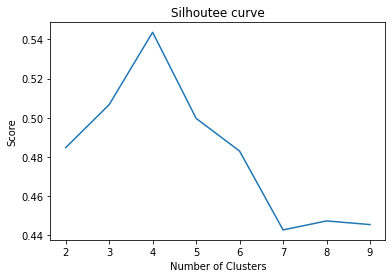

In [43]:
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Silhoutee curve')
pl.show()